In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import utils # local file

#plt.rcParams['figure.dpi'] = 200.0
#plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 15.0
#plt.rcParams['text.usetex'] = False

In [50]:
df = pd.read_csv('./2020_Problem_D_DATA/passingevents.csv')
df = df[df['MatchID'] == 2]
# df.sort_values('TeamID')
# df = df[np.logical_or(df['TeamID'] == 'Huskies', df['TeamID'] == 'Opponent1')]
df

,MatchID,TeamID,OriginPlayerID,DestinationPlayerID,MatchPeriod,EventTime,EventSubType,EventOrigin_x,EventOrigin_y,EventDestination_x,EventDestination_y
566,2,Opponent2,Opponent2_F1,Opponent2_M1,1H,1.695556,Simple pass,49,48,43.0,51.0
567,2,Opponent2,Opponent2_M1,Opponent2_D1,1H,4.861993,High pass,43,51,78.0,80.0
568,2,Opponent2,Opponent2_D1,Opponent2_F2,1H,7.127170,Simple pass,78,80,83.0,77.0
569,2,Opponent2,Opponent2_D2,Opponent2_F1,1H,37.255054,Head pass,33,48,61.0,60.0
570,2,Huskies,Huskies_F2,Huskies_D4,1H,43.463685,Simple pass,43,26,41.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...
1157,2,Opponent2,Opponent2_D5,Opponent2_M5,2H,2865.857573,Simple pass,72,77,77.0,59.0
1158,2,Huskies,Huskies_D1,Huskies_D6,2H,2932.852162,Head pass,30,73,33.0,91.0
1159,2,Opponent2,Opponent2_M1,Opponent2_M2,2H,2939.922357,Head pass,41,10,64.0,30.0
1160,2,Opponent2,Opponent2_F2,Opponent2_M4,2H,2944.309644,Head pass,71,51,53.0,55.0


In [51]:
df = df[df['TeamID'] == 'Huskies'] # We only study Huskies now

In [52]:
# calculate average position of each player
uniq_player = np.unique(
    np.union1d(df['OriginPlayerID'], df['DestinationPlayerID']))
x_mean = [
    np.mean(
        list(df[df['OriginPlayerID'] == name]['EventOrigin_x']) +
        list(df[df['DestinationPlayerID'] == name]['EventDestination_x']))
    for name in uniq_player
]
y_mean = [
    np.mean(
        list(df[df['OriginPlayerID'] == name]['EventOrigin_y']) +
        list(df[df['DestinationPlayerID'] == name]['EventDestination_y']))
    for name in uniq_player
]

pos = {
    name: np.array([x_mean[i], y_mean[i]])
    for i, name in enumerate(uniq_player)
}

In [53]:
# Build Directional graph
G = nx.from_pandas_edgelist(df, source='OriginPlayerID', 
                            target='DestinationPlayerID', 
                            edge_attr=True, 
                            create_using=nx.DiGraph())

In [54]:
# Calculate degree centrality
deg_centrality = nx.algorithms.centrality.degree_centrality(G)
deg_centrality = np.array([deg_centrality[node] for node in list(G.nodes())])

# Calculate betweenness centrality
between_centrality = nx.algorithms.centrality.betweenness_centrality(G)
between_centrality = np.array([between_centrality[node] for node in list(G.nodes())])

# Calculate eigenvector centrality
eigen_centrality = nx.algorithms.centrality.eigenvector_centrality(G)
eigen_centrality = np.array([eigen_centrality[node] for node in list(G.nodes())])

# Calculate total (in + out) passes through a node
#huskie_passes = utils.match_i_Opponent_passing_table('./2020_Problem_D_DATA/passingevents.csv', 
#                                                    match_i=2)
huskie_passes = utils.match_i_Huskies_passing_table('./2020_Problem_D_DATA/passingevents.csv', 
                                                    match_i=2)
node_passes = np.array([np.sum(huskie_passes[node]) for node in list(G.nodes())])

In [55]:
## Calculate passes from A to B
df_huskies = df[['OriginPlayerID', 'DestinationPlayerID']]
# Multi-Directional graph
H = nx.from_pandas_edgelist(df_huskies, source='OriginPlayerID', 
                            target='DestinationPlayerID', edge_attr=True, 
                            create_using=nx.MultiDiGraph())

unidirection_pass = {}
for edge in H.edges:
    unidirection_pass[(edge[0], edge[1])] = H.number_of_edges(edge[0], edge[1])

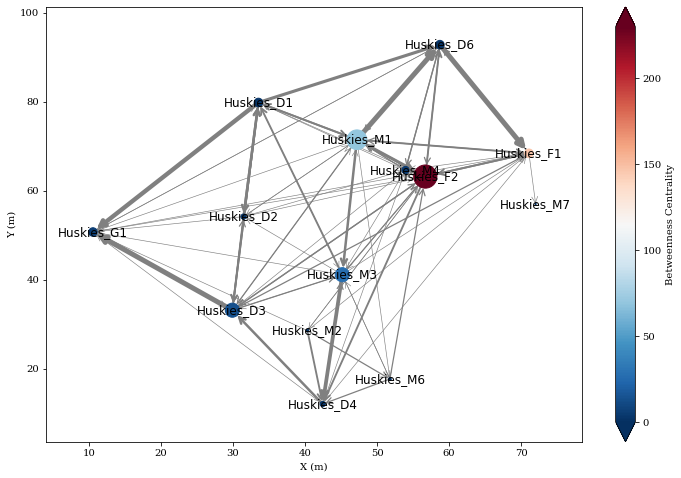

In [56]:
# Plot the network
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw_networkx(G, pos, ax=ax, 
                 node_size=np.exp(4.3 * deg_centrality), 
                 node_color=np.exp(50 * between_centrality), 
                 edgelist=list(unidirection_pass.keys()), 
                 width=np.array(list(unidirection_pass.values())) / 1.6,
                 edge_color='gray', cmap='RdBu_r', vmin=0, vmax=230, arrowsize=15, arrowstyle='->')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=0, vmax=230))
cbar = plt.colorbar(sm, ax=ax, extend='both')
cbar.set_label('Betweenness Centrality')
#fig.colorbar(neg, ax=ax)
#, width=edge_passes)

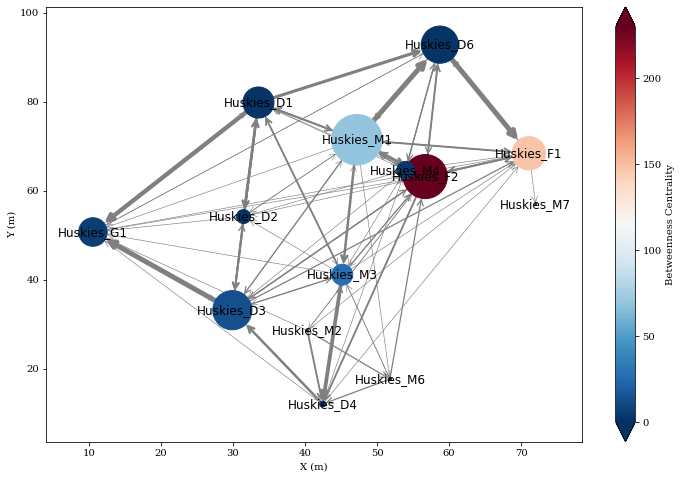

In [57]:
# Plot the network
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw_networkx(G, pos, ax=ax, 
                 node_size=np.exp(22 * eigen_centrality), 
                 node_color=np.exp(50 * between_centrality), 
                 edgelist=list(unidirection_pass.keys()), 
                 width=np.array(list(unidirection_pass.values())) / 1.6,
                 edge_color='gray', cmap='RdBu_r', vmin=0, vmax=230, arrowsize=15, arrowstyle='->')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=0, vmax=230))
cbar = plt.colorbar(sm, ax=ax, extend='both')
cbar.set_label('Betweenness Centrality')
#fig.colorbar(neg, ax=ax)
#, width=edge_passes)

In [91]:
# get attributes of an edge
G.get_edge_data('Huskies_D3', 'Huskies_D2')

{'MatchID': 1,
 'TeamID': 'Huskies',
 'OriginPlayerID': 'Huskies_D3',
 'DestinationPlayerID': 'Huskies_D2',
 'MatchPeriod': '1H',
 'EventTime': 766.375013,
 'EventSubType': 'Simple pass',
 'EventOrigin_x': 26,
 'EventOrigin_y': 15,
 'EventDestination_x': 28.0,
 'EventDestination_y': 46.0}

## Calculate motifs in the network

In [14]:
## We define each S* motif as a directed graph in networkx
## up=1, down=3, right=2
motifs = {
    'S1': nx.DiGraph([(2,1),(2,3)]),
    'S2': nx.DiGraph([(3,2),(2,1)]),
    'S3': nx.DiGraph([(3,2),(2,3),(2,1)]),
    'S4': nx.DiGraph([(3,1),(2,1)]),
    'S5': nx.DiGraph([(3,1),(2,1),(2,3)]),
    'S6': nx.DiGraph([(3,1),(2,1),(2,3),(3,2)]),
    'S7': nx.DiGraph([(3,2),(2,3),(1,2)]),
    'S8': nx.DiGraph([(3,2),(2,3),(2,1),(1,2)]),
    'S9': nx.DiGraph([(1,2),(2,3),(3,1)]),
    'S10': nx.DiGraph([(1,2),(2,3),(3,1),(2,1)]),
    'S11': nx.DiGraph([(1,2),(2,1),(3,2),(3,1)]),
    'S12': nx.DiGraph([(1,2),(2,1),(3,2),(2,3),(3,1)]),
    'S13': nx.DiGraph([(1,2),(2,1),(2,3),(3,2),(3,1),(1,3)])
    }

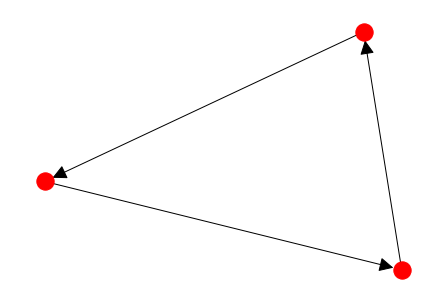

In [18]:
nx.draw(motifs['S9'], arrowsize=30)

In [16]:
from utils import mcounter
mcounter(G, motifs)

{'S1': 9,
 'S2': 18,
 'S3': 21,
 'S4': 11,
 'S5': 9,
 'S6': 10,
 'S7': 17,
 'S8': 13,
 'S9': 5,
 'S10': 14,
 'S11': 5,
 'S12': 34,
 'S13': 14}